In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx
/kaggle/input/widsdatathon2025/Data Dictionary.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx
/kaggle/input/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv
/kaggle/input/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx
/kaggle/input/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx
/kaggle/input/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx


## Loading the Data Frames

In [3]:
# Categorical Meta data 
file_path_trainC = "/kaggle/input/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
train_cat = pd.read_excel(file_path_trainC)
train_cat.head()

,participant_id,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
0,UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
1,CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
2,Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
3,p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
4,M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0


In [4]:
train_cat.columns

Index(['participant_id', 'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')

In [5]:
# Functional Conncectome Matrices
# Describes the interactions between different brain regions and is given in the form of a matrix
# +ve values brain regions are more active together while -ve values brain regions are less active together
file_path_trainFCM = '/kaggle/input/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv'
train_FCM = pd.read_csv(file_path_trainFCM)
train_FCM.head()

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269


In [6]:
train_FCM.columns

Index(['participant_id', '0throw_1thcolumn', '0throw_2thcolumn',
       '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn',
       '0throw_6thcolumn', '0throw_7thcolumn', '0throw_8thcolumn',
       '0throw_9thcolumn',
       ...
       '195throw_196thcolumn', '195throw_197thcolumn', '195throw_198thcolumn',
       '195throw_199thcolumn', '196throw_197thcolumn', '196throw_198thcolumn',
       '196throw_199thcolumn', '197throw_198thcolumn', '197throw_199thcolumn',
       '198throw_199thcolumn'],
      dtype='object', length=19901)

In [7]:
# Quantitative Meta data of the participants(Socio-demographic Information)
file_path_trainQ = '/kaggle/input/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx'
train_Quant = pd.read_excel(file_path_trainQ)
train_Quant.head()

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679


In [8]:
train_Quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [9]:
# ADHD Diagnosis and Gender of Pearicipants
# female:1, male:0,ADHD:1, no ADHD:0 -> Target Variables
file_path_trainS = '/kaggle/input/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx'
train_Solutions = pd.read_excel(file_path_trainS)
train_Solutions.head()

,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1


In [10]:
train_Solutions.columns

Index(['participant_id', 'ADHD_Outcome', 'Sex_F'], dtype='object')

# > Exploring our Data 
## EDA(Explanatory Data Analysis)
The process of examining and summarizing data to uncover patterns, spor problems and prepare for modeling. This helps us to understand the dataset, Detect issues(missing, data and trends) and Discover relationships and trends.
Use of .info() and .describe() to summarize the data set 
And use of .value_counts()



In [11]:
train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   participant_id                    1213 non-null   object 
 1   Basic_Demos_Enroll_Year           1213 non-null   int64  
 2   Basic_Demos_Study_Site            1213 non-null   int64  
 3   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 4   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 5   MRI_Track_Scan_Location           1213 non-null   int64  
 6   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 7   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 8   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 9   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 94.9+ KB


In [12]:
train_cat.describe()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
count,1213.000000,1213.000000,1202.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,2017.652102,2.014839,0.424293,2.080791,2.288541,17.641385,24.892828,14.122012,24.719703
std,1.122522,1.135147,0.687470,3.164636,0.758348,4.004639,17.025899,7.201023,17.171113
min,2015.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,1.000000,0.000000,0.000000,2.000000,15.000000,0.000000,12.000000,5.000000
50%,2018.000000,1.000000,0.000000,0.000000,2.000000,18.000000,30.000000,18.000000,30.000000
75%,2019.000000,3.000000,1.000000,2.000000,3.000000,21.000000,40.000000,21.000000,40.000000
max,2020.000000,4.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,45.000000


### Distribution of ADHD between the two genders

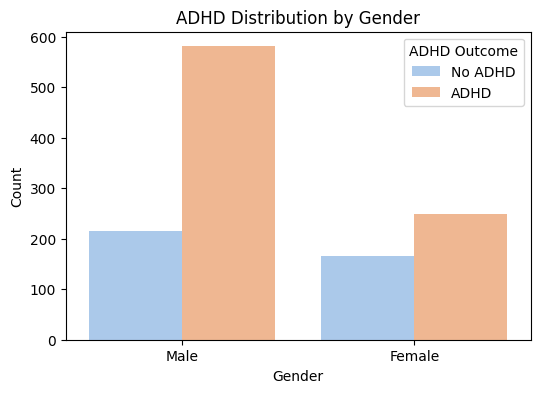

In [13]:
# Plot ADHD cases by gender
plt.figure(figsize=(6, 4))
sns.countplot(data=train_Solutions, x="Sex_F", hue="ADHD_Outcome", palette="pastel")

# Customize the plot
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("ADHD Distribution by Gender")
plt.legend(title="ADHD Outcome", labels=["No ADHD", "ADHD"])
plt.show()


### From the graph above we can conclude the following 
1. There are more males than Females in the dataset
2. The participants with ADHD are more that those with no ADHD
3. More males have ADHD than females

This may introduce bias in modelling.

### Distribution of Age at time of Scan for the Participants
The ages of Participants was between 5-22 years

In [14]:
train_Quant.columns

Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

In [15]:
train_Quant['MRI_Track_Age_at_Scan'].describe()

count    853.000000
mean      11.245678
std        3.234372
min        0.000000
25%        8.803901
50%       10.739219
75%       13.460871
max       21.564453
Name: MRI_Track_Age_at_Scan, dtype: float64

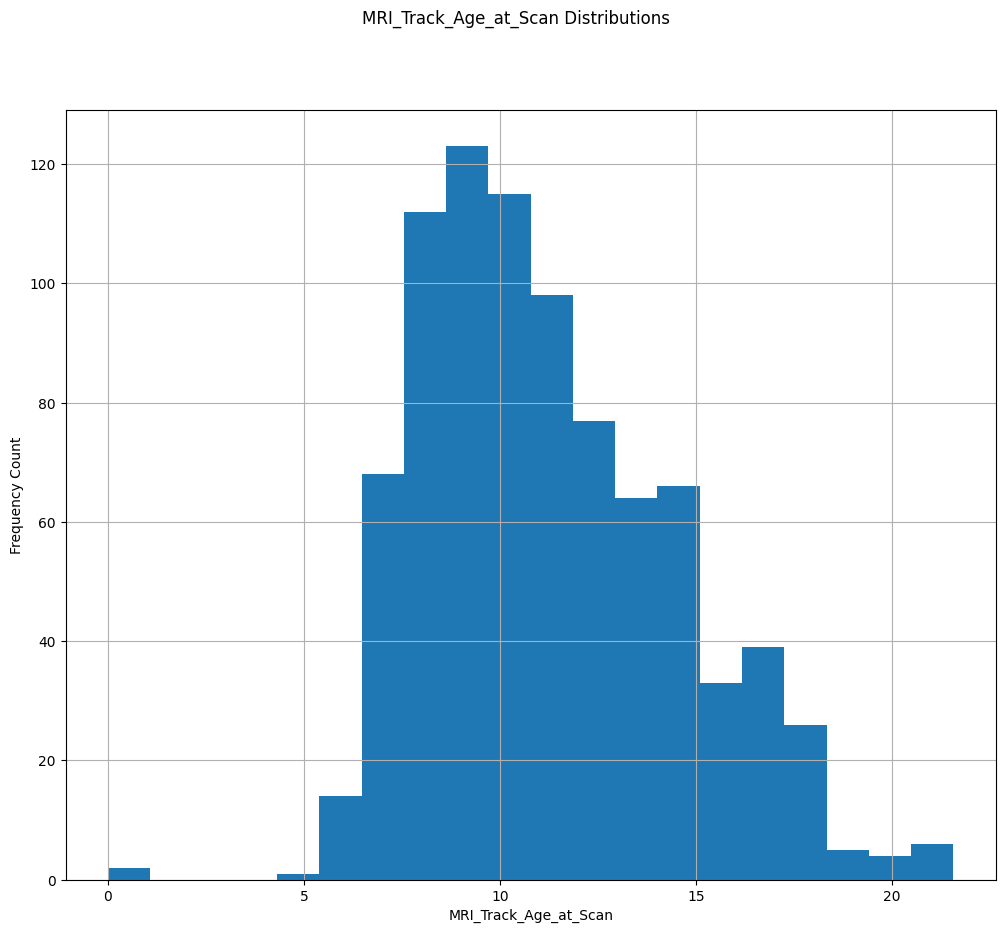

In [16]:
# Distribution of MRI_Track_Age_at_Scan
train_Quant['MRI_Track_Age_at_Scan'].hist(figsize=(12, 10), bins=20)
plt.suptitle("MRI_Track_Age_at_Scan Distributions")
plt.xlabel('MRI_Track_Age_at_Scan')
plt.ylabel('Frequency Count')
plt.show()

The majority of the participants are between 7 and 13 years old. Since puberty typically begins between ages 8–13 for girls and 9–14 for boys, we can infer that most participants are in puberty.

### Distribution of SDQ_SDQ_Emotional Problems
This is from the Strengths and Difficulties Questionnaire showing the Emotional Problems scales


In [17]:
train_Quant['SDQ_SDQ_Hyperactivity'].describe()

count    1213.000000
mean        5.497939
std         2.836764
min         0.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: SDQ_SDQ_Hyperactivity, dtype: float64

In [18]:
train_Quant['SDQ_SDQ_Emotional_Problems'].describe()

count    1213.000000
mean        2.307502
std         2.167549
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        10.000000
Name: SDQ_SDQ_Emotional_Problems, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


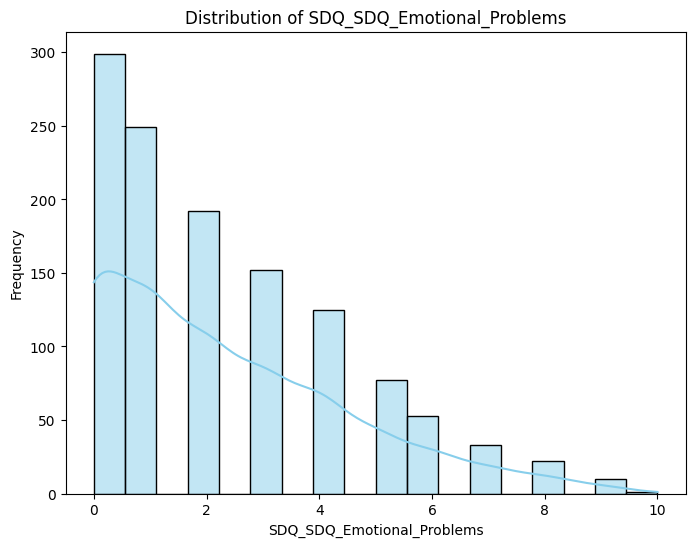

In [19]:
# Plot the distribution of the SDQ_SDQ_Emotional_Problems variable
plt.figure(figsize=(8, 6))
sns.histplot(train_Quant['SDQ_SDQ_Emotional_Problems'], kde=True, color='skyblue')
plt.title('Distribution of SDQ_SDQ_Emotional_Problems')
plt.xlabel('SDQ_SDQ_Emotional_Problems')
plt.ylabel('Frequency')
plt.show()

### Is there a relationship between Emotional Problems scale and ADHD Outcome
This boxplot examines the relationship between SDQ_SDQ_Emotional_Problems and ADHD_outcome (as a target variable).

In [20]:
train_Quant.columns


Index(['participant_id', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')

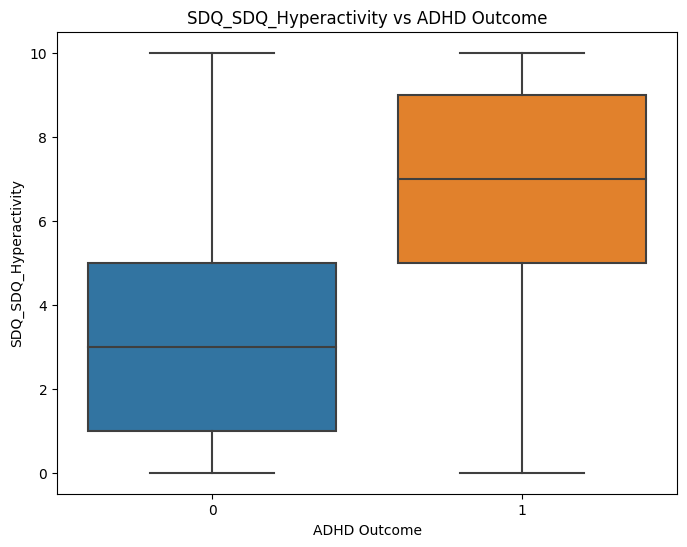

In [21]:
# Check for correlation with ADHD outcome
train_Quant_copy = train_Quant.copy()
train_Quant_copy['ADHD_Outcome'] = train_Solutions['ADHD_Outcome']

plt.figure(figsize=(8, 6))
sns.boxplot(x='ADHD_Outcome', y='SDQ_SDQ_Hyperactivity', data=train_Quant_copy)
plt.title('SDQ_SDQ_Hyperactivity vs ADHD Outcome')
plt.xlabel('ADHD Outcome')
plt.ylabel('SDQ_SDQ_Hyperactivity')
plt.show()


The median for individuals with ADHD is higher than those without ADHD.
This means we can associate ADHD with hyperactivity. It is good to note that this symptom is more present in males than females. Since Females have more inattentive characteristics.